In [1]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import Dataset

import heartpy as hp
from heartpy.exceptions import BadSignalWarning
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks, fit_peaks

from numpy.lib.stride_tricks import as_strided

RR_WINDOW_SIZE = 60

FS = 128
DFS = 50

AF = 1
NON_AF = 0

LOW_FREQ_FILTER = (30 / 60)
HI_FREQ_FILTER = (240 / 60)

print(f'Bandpass filter frequencies: [ {LOW_FREQ_FILTER}, {HI_FREQ_FILTER} ]')

Bandpass filter frequencies: [ 0.5, 4.0 ]


In [2]:
class PPGDataset(Dataset):
    def __init__(self, data_path, freq):
        self.freq = freq
        self.data_path = data_path
        data_files = os.listdir(data_path)

        # File discovery
        self.subjects = {f[:4] for f in data_files if f[:4].isdigit()}
        self.signal_files = [os.path.join(data_path, s + '.mat') for s in self.subjects]
        self.ground_truth_files = [os.path.join(data_path, s + '_ground_truth.mat') for s in self.subjects]

        # self.ground_truth_files = [f for f in data_files if 'ground_truth' in f]
        # self.peak_ref_files = [f for f in data_files if 'Peak_Ref_ECG' in f]
        # self.ecg_30_sec_files = [f for f in data_files if 'ECG_30sec' in f]
        # self.ref_ecg_files = [f for f in data_files if 'RefECG' in f]

        self.info_file = None
        if 'UMass_SimbandInfo.mat' in data_files:
            self.info_file = os.path.join(data_path, 'UMass_SimbandInfo.mat')

        # self.signal_files = set(data_files) - set(self.ground_truth_files + self.peak_ref_files + self.ecg_30_sec_files + self.ref_ecg_files + [self.info_file])
        # self.signal_files = list(self.signal_files)
        # print('signal_files:', self.signal_files)
        # self.subjects = [int(os.path.splitext(x)[0]) for x in self.signal_files]
        # self.subjects.sort()

        self.cache = {}
        self.data = []
        self.rr_intervals = []

    # def get_raw_ppg_signal(self, pid, channel=0):
    #     signal_file = os.path.join(self.data_path, f'{pid}.mat')
    #     _data = scipy.io.loadmat(signal_file, matlab_compatible=True, simplify_cells=True)
    #     if channel not in range(8):
    #         channel = 0
    #     return _data['data']['physiosignal']['ppg'][chr(ord('a') + channel)]['signal']

    def bandpass_filter(self, x, filter_order=2):
        return hp.filter_signal(x, [LOW_FREQ_FILTER, HI_FREQ_FILTER], sample_rate=self.freq, order=filter_order, filtertype='bandpass')

    def get_ppg_signal(self, pid, filter=True):
        signal_file = os.path.join(self.data_path, f'{pid}.mat')
        _data = scipy.io.loadmat(signal_file, matlab_compatible=True, simplify_cells=True)
        if filter:
            return self.bandpass_filter(_data['PPG_FULL'])
        return _data['PPG_FULL']

    def get_ground_truth(self, pid):
        gt_file = os.path.join(self.data_path, f'{pid}_ground_truth.mat')
        _data = scipy.io.loadmat(gt_file, matlab_compatible=True, simplify_cells=True)
        _gt = _data['disease_label']
        return (_gt[:,1:] == AF).flatten().astype(float)

    def process_signals(self):
        window_size = 30 * self.freq
        sub_window_size = window_size // 3

        for subject in self.subjects:
            sig = self.get_ppg_signal(subject)
            gt = self.get_ground_truth(subject)
            rrs = []
            gts = []
            for i in range(len(gt)):
                window = sig[window_size*i:window_size*(i+1)]
                rol_mean = rolling_mean(window, windowsize=1, sample_rate=DFS)
                wd = detect_peaks(window, rol_mean, ma_perc=20, sample_rate=DFS)
                rr = wd['RR_list']
                rrs.append(rr)
                gts.append(np.ones_like(rr) * gt[i])
            
            rrs = np.hstack(rrs)
            gts = np.hstack(gts)

            rrs = as_strided(rrs,shape=(len(rrs)//RR_WINDOW_SIZE, RR_WINDOW_SIZE))
            gts = as_strided(gts,shape=(len(gts)//RR_WINDOW_SIZE, RR_WINDOW_SIZE))

            prec = 0
            for i in range(rrs.shape[0]):
                # Filtering / Masking ignorance should go here
                self.rr_intervals.append((rrs[i], gts[i], prec, subject))
                prec += 1

                # for j in range(3):
                #     start_idx = window_size*i + sub_window_size*j
                #     end_idx = start_idx + sub_window_size
                #     self.data.append((sig[start_idx:end_idx], gt[i]))

    def window(self, x, freq, start=0, sec=10):
        start_idx = math.floor(start * freq)
        end_idx = math.floor(start_idx + sec * freq)
        return x[start_idx:end_idx]

    def __len__(self):
        return len(self.rr_intervals)

    def __getitem__(self, idx):
        return self.rr_intervals[idx]

In [3]:
dataset = PPGDataset('data', freq=DFS)
dataset.process_signals()

In [8]:
x = dataset[0]
x

(array([  80., 1780.,  140., 1540.,  100., 1680., 6100., 1600.,  740.,
         840.,  620., 1040.,  800.,  120.,  380.,  660.,  980.,  900.,
        1000.,  960.,  280.,  640.,  640.,  520.,   60.,  480.,  260.,
         660.,  280.,  720.,  340.,  720.,  800.,  580.,  720.,  540.,
         580., 1040.,  660.,  280.,  280.,  560.,  320.,  600., 1100.,
        1040.,  880., 1080.,  300.,  660.,  980.,  780., 1140., 1000.,
         300.,  600.,  940.,  840.,  600.,  660.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 0,
 '4030')

In [28]:
total = 0
af = 0
sigs = []
for subject in dataset.subjects:
    gt = dataset.get_ground_truth(subject)
    total += 1
    if 1 in gt:
        af += 1
    sig = dataset.get_ppg_signal(subject)
    print('Subject ', subject, ' recording duration: {:.2f}'.format(len(sig) / (DFS*60)), 'minutes')
    sigs.append(sig)


print('total=', total)
print('af=', af)

Subject  4035  recording duration: 15.35 minutes
Subject  4031  recording duration: 45.77 minutes
Subject  4013  recording duration: 14.28 minutes
Subject  4038  recording duration: 49.71 minutes
Subject  4030  recording duration: 34.67 minutes
Subject  4002  recording duration: 22.87 minutes
Subject  4027  recording duration: 50.70 minutes
Subject  4024  recording duration: 67.47 minutes
Subject  4019  recording duration: 27.31 minutes
Subject  4020  recording duration: 24.68 minutes
Subject  4026  recording duration: 53.58 minutes
Subject  4009  recording duration: 23.07 minutes
Subject  4043  recording duration: 36.25 minutes
Subject  4034  recording duration: 44.57 minutes
Subject  4001  recording duration: 23.56 minutes
Subject  4006  recording duration: 23.64 minutes
Subject  4039  recording duration: 19.47 minutes
Subject  4033  recording duration: 48.08 minutes
Subject  4007  recording duration: 52.43 minutes
Subject  4028  recording duration: 32.38 minutes
Subject  4037  recor

In [13]:
avg_signal_length = sum([len(x) for x in sigs]) / total
avg_signal_length

119273.29268292683

In [20]:
avg_signal_length / (DFS)

2385.4658536585366

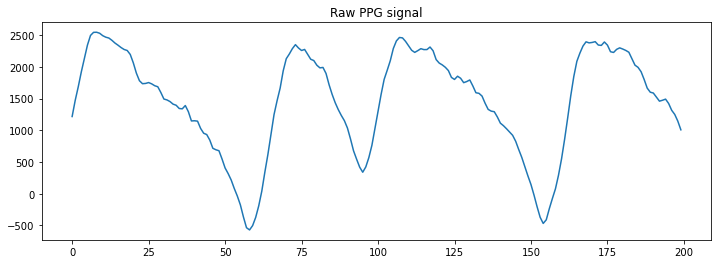

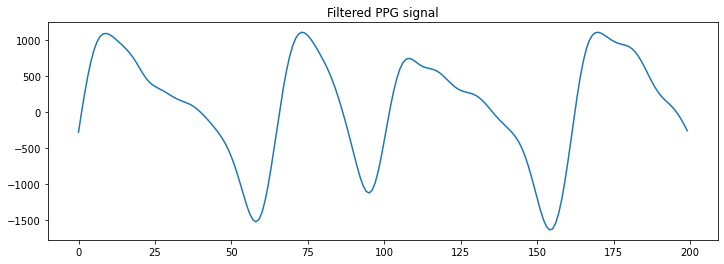

In [32]:
x = dataset.get_ppg_signal(4001, filter=False)
xf = dataset.get_ppg_signal(4001, filter=True)

t1 = 3000
t2 = 3200

plt.figure(figsize=(12,4))
plt.title('Raw PPG signal')
plt.plot(x[t1:t2])
plt.show()

plt.figure(figsize=(12,4))
plt.title('Filtered PPG signal')
plt.plot(xf[t1:t2])
plt.show()

In [65]:
len(dataset.rr_intervals)

2221

In [67]:
dataset.rr_intervals[1]

(array([ 500.,  760.,  460.,  780., 1420.,  980., 1240., 1200., 1220.,
         400.,  840., 1160.,  340.,  860., 1160., 1200., 1200.,  160.,
        1040.,  720.,  540., 1160., 1160.,  200., 1020., 1200.,  600.,
         620., 1120.,  200., 1020.,  280.,  960., 1120.,  380.,  780.,
        1200.,  520.,  700., 1120.,  460.,  760., 1180., 1120., 1220.,
        1180.,  500.,  640.,  220., 1020.,  180.,  960., 1180., 1160.,
        1200.,  640.,  560., 1160., 1200.,  200.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 1,
 '4035')

In [21]:
for i in range(len(dataset)):
    X,y,pid = dataset[i]
    if 1 in y:
        print('found AF for ', pid)
        break

found AF for  4016


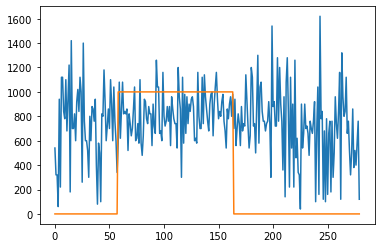

In [25]:
plt.figure()

t1 = 20
t2 = 300

plt.plot(X[t1:t2])
plt.plot((y*1000)[t1:t2])
plt.show()

In [29]:
X.shape

(1561,)

In [48]:
X[:60], X[60:120]

(array([1200.,  560.,  800.,  760., 1300.,  780.,  420.,  960.,  700.,
         820., 1020.,  860.,  160., 1100.,  380.,  640.,  660.,  760.,
         720., 1280.,  540.,  320.,  320.,   60.,  940.,  220., 1120.,
        1120.,  840.,  780., 1100.,  680.,  940., 1220.,  180., 1420.,
         700.,  700.,  820.,  600.,  920., 1020.,  840., 1120., 1000.,
         260., 1400.,  760.,  600.,  600.,  520.,  300.,  800.,  600.,
         880.,  860.,  760.,  940.,  400.,   80.]),
 array([ 580.,  500.,  100.,  820.,  800., 1180.,  920.,  600.,  720.,
         860.,  700., 1100.,  900.,  600., 1040.,  760.,  600.,  340.,
         580., 1080.,  620.,  860., 1080.,  820.,  840.,  820.,  860.,
         520.,  820.,  740.,  640.,  700.,  860., 1040.,  600.,  620.,
         740.,  580., 1100.,  580.,  480.,  640.,  940.,  920.,  780.,
         740.,  880.,  820.,  820.,  560.,  900.,  720.,  660., 1260.,
        1040., 1040.,  660.,  680.,  600., 1160.]))

In [51]:
swid = np.lib.stride_tricks.as_strided(X,shape=(len(X)//60, 60))
swid.shape

(26, 60)

In [56]:
[swid[i,:] for i in range(swid.shape[0])]

[array([1200.,  560.,  800.,  760., 1300.,  780.,  420.,  960.,  700.,
         820., 1020.,  860.,  160., 1100.,  380.,  640.,  660.,  760.,
         720., 1280.,  540.,  320.,  320.,   60.,  940.,  220., 1120.,
        1120.,  840.,  780., 1100.,  680.,  940., 1220.,  180., 1420.,
         700.,  700.,  820.,  600.,  920., 1020.,  840., 1120., 1000.,
         260., 1400.,  760.,  600.,  600.,  520.,  300.,  800.,  600.,
         880.,  860.,  760.,  940.,  400.,   80.]),
 array([ 580.,  500.,  100.,  820.,  800., 1180.,  920.,  600.,  720.,
         860.,  700., 1100.,  900.,  600., 1040.,  760.,  600.,  340.,
         580., 1080.,  620.,  860., 1080.,  820.,  840.,  820.,  860.,
         520.,  820.,  740.,  640.,  700.,  860., 1040.,  600.,  620.,
         740.,  580., 1100.,  580.,  480.,  640.,  940.,  920.,  780.,
         740.,  880.,  820.,  820.,  560.,  900.,  720.,  660., 1260.,
        1040., 1040.,  660.,  680.,  600., 1160.]),
 array([ 800.,  720.,  760.,  880.,  760.,  

In [52]:
26*60

1560

In [30]:
swid = np.lib.stride_tricks.sliding_window_view(X, window_shape=(60))

swid[0]

array([1200.,  560.,  800.,  760., 1300.,  780.,  420.,  960.,  700.,
        820., 1020.,  860.,  160., 1100.,  380.,  640.,  660.,  760.,
        720., 1280.,  540.,  320.,  320.,   60.,  940.,  220., 1120.,
       1120.,  840.,  780., 1100.,  680.,  940., 1220.,  180., 1420.,
        700.,  700.,  820.,  600.,  920., 1020.,  840., 1120., 1000.,
        260., 1400.,  760.,  600.,  600.,  520.,  300.,  800.,  600.,
        880.,  860.,  760.,  940.,  400.,   80.])

In [31]:
swid[1]

array([ 560.,  800.,  760., 1300.,  780.,  420.,  960.,  700.,  820.,
       1020.,  860.,  160., 1100.,  380.,  640.,  660.,  760.,  720.,
       1280.,  540.,  320.,  320.,   60.,  940.,  220., 1120., 1120.,
        840.,  780., 1100.,  680.,  940., 1220.,  180., 1420.,  700.,
        700.,  820.,  600.,  920., 1020.,  840., 1120., 1000.,  260.,
       1400.,  760.,  600.,  600.,  520.,  300.,  800.,  600.,  880.,
        860.,  760.,  940.,  400.,   80.,  580.])

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/heartpy/visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


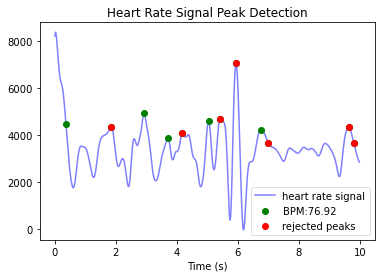

In [63]:
wd, measures = hp.process(dataset.data[200][0], sample_rate=DFS, windowsize=1.2)
hp.plotter(wd, measures)

In [31]:
rmssd = []
bpm = []
for sig, gt in dataset.data:
    try:
        wd, measures = hp.process(sig, sample_rate=DFS, windowsize=1.2)
        rmssd.append(measures['rmssd'])
        bpm.append(measures['bpm'])
    except BadSignalWarning:
        continue

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

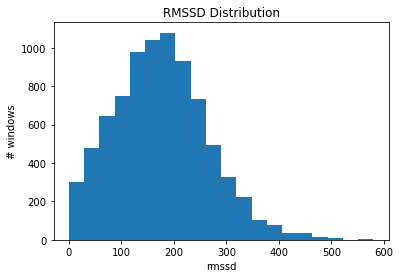

In [36]:
plt.figure()
plt.title('RMSSD Distribution')
plt.hist(rmssd, bins=20)
plt.xlabel('rmssd')
plt.ylabel('# windows')
plt.show()

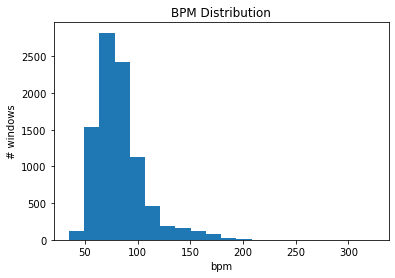

In [35]:
plt.figure()
plt.title('BPM Distribution')
plt.hist(bpm, bins=20)
plt.xlabel('bpm')
plt.ylabel('# windows')
plt.show()

In [48]:
sig,gt = dataset.data[300]
wd, measures = hp.process(sig, sample_rate=DFS, windowsize=3)
rol_mean = rolling_mean(sig, windowsize = 1, sample_rate = DFS)
wd = detect_peaks(sig, rol_mean, ma_perc = 20, sample_rate = DFS)
wd.keys()

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


dict_keys(['peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd'])

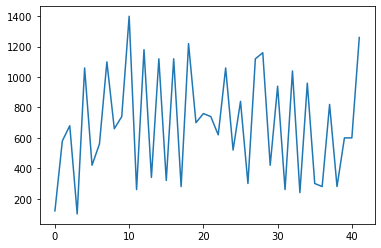

In [64]:
plt.figure()
plt.plot(dataset.rr_intervals[200][0])
plt.show()